# 04a - BigQuery Machine Learning (BQML) - Univariate Forecasting with ARIMA+


### Prerequisites:
- 04 - Time Series Forecasting - Data Review in BigQuery

### Overview:
- Setup
- Review Time Series
- Create Forecast Model
    - Review the ARIMA coefficients
    - Review the input features
    - Review the training information
- Forecast Evaluation
    - Forecast metrics
    - Evaluate time series models
- Forecast Time Series
- Forecast + Explaination for Time Series
    - Visualize Time Series with Forecast
- Using SQL to Calculate Metrics
- Anomaly Detection
    - Visualize Time Series with Forecast and Anomalies

### Resources:
- [Bigquery ML End-to-end user journey for each model](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [How to do time series forecasting in BigQuery](https://towardsdatascience.com/how-to-do-time-series-forecasting-in-bigquery-af9eb6be8159)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Codelab: Time Series Forecasting with Vertex AI and BigQuery ML](https://codelabs.developers.google.com/codelabs/time-series-forecasting-with-cloud-ai-platform#0)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04a_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04a_console.png">

---
## Setup

inputs:

In [1]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04a'

packages:

In [2]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [3]:
bigquery = bigquery.Client()

---
## Review Time Series

Retrieve Key Dates for splits:

In [7]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-08-31,2016-09-15,2016-09-30,16


Retrieve raw data:

In [11]:
query = f"""
SELECT start_station_name, date, splits, num_trips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by start_station_name, date
"""
rawSeries = bigquery.query(query = query).to_dataframe()

Visualize time series:

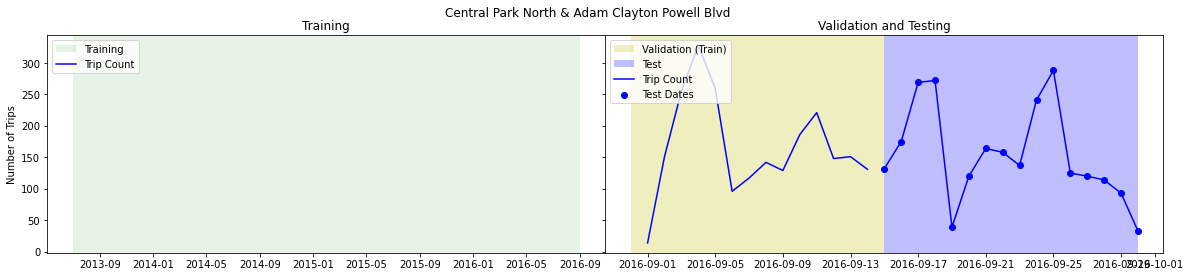

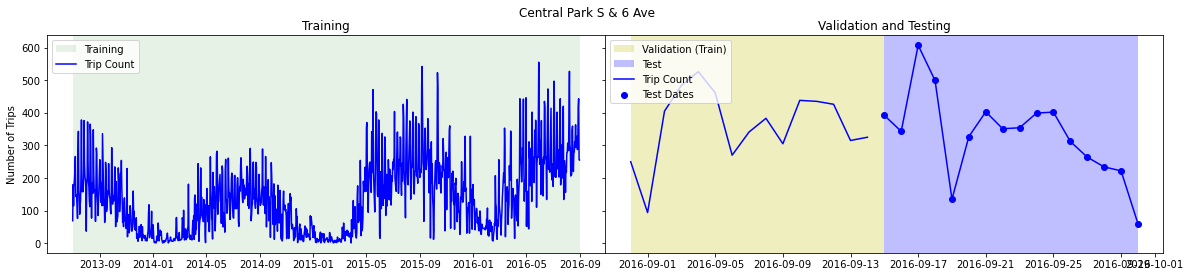

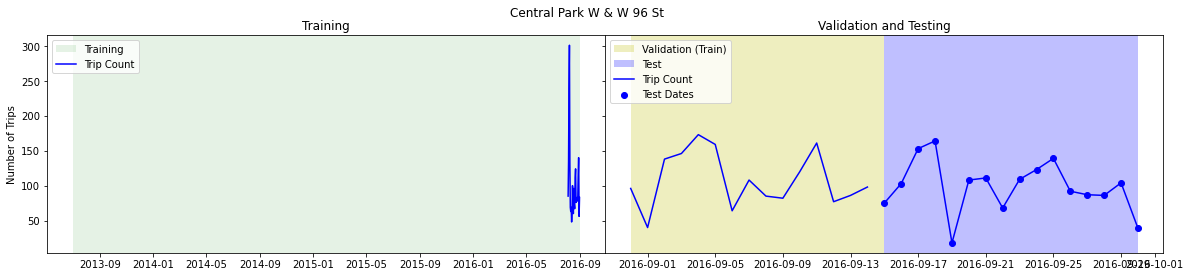

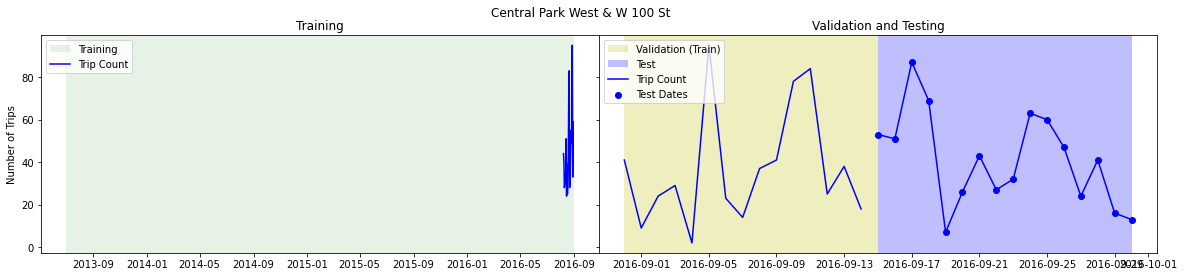

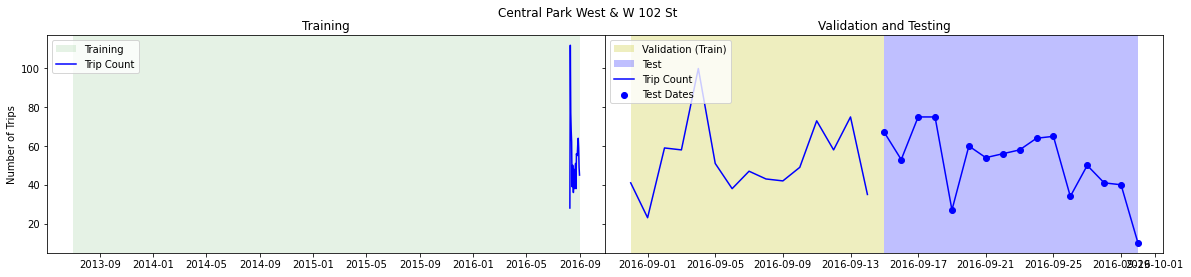

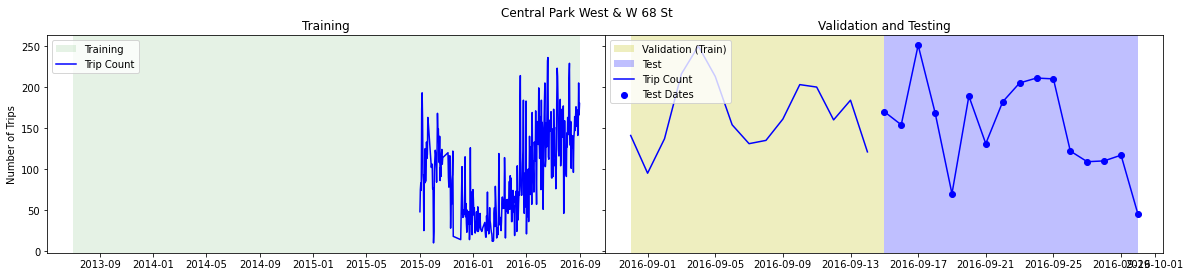

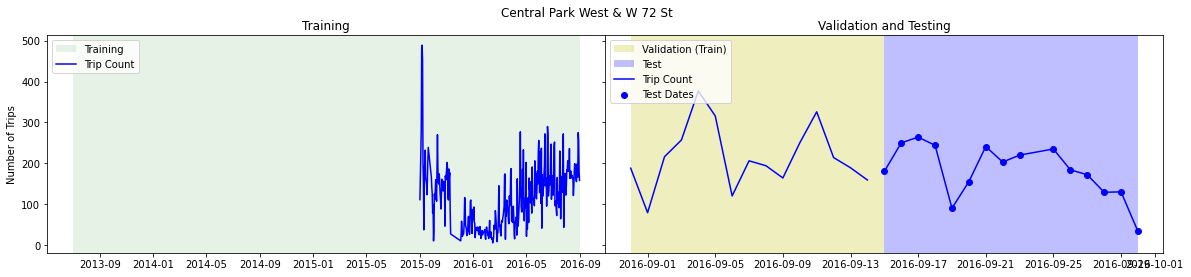

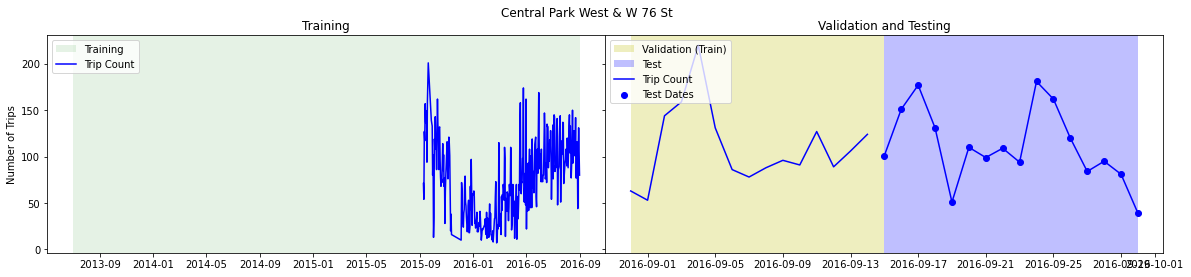

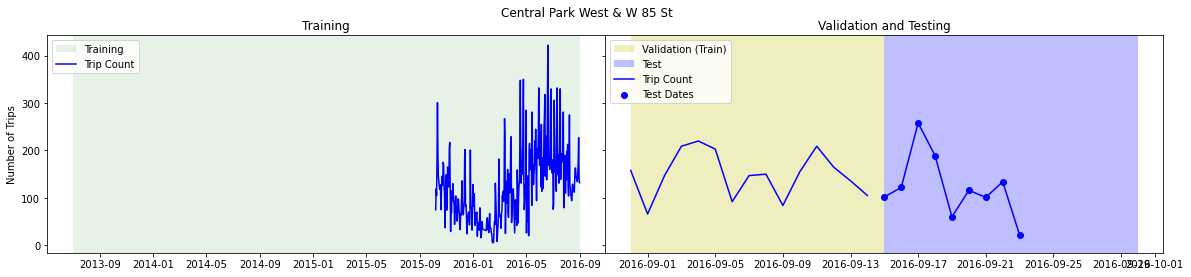

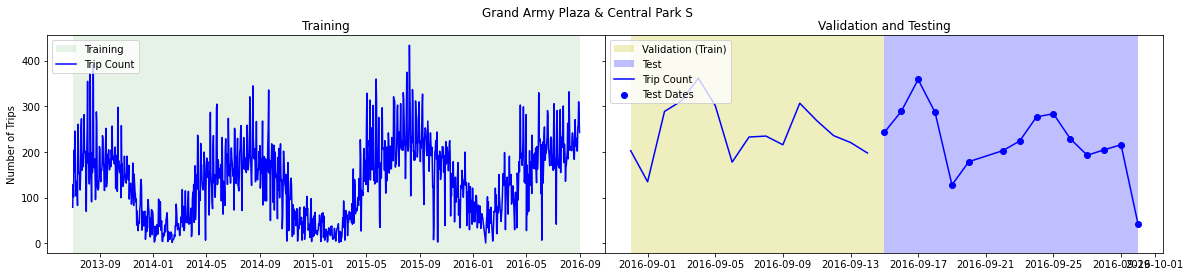

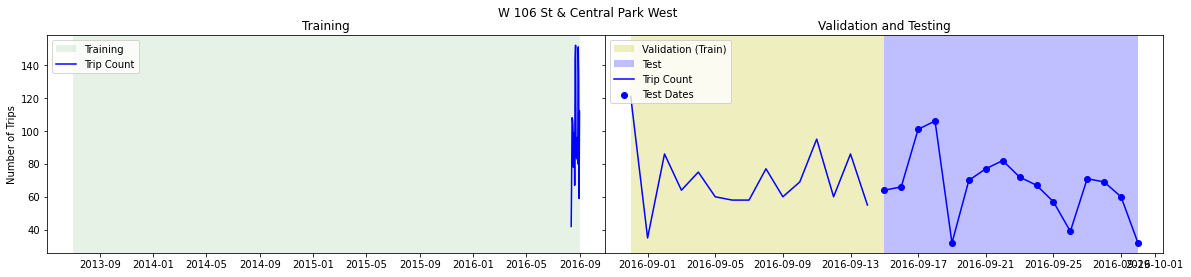

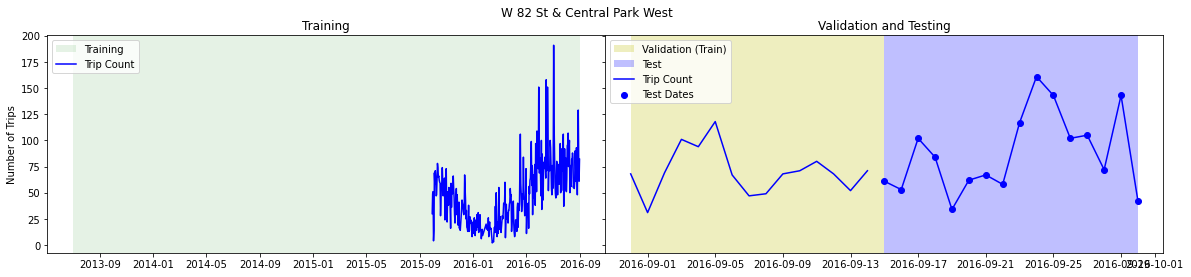

In [12]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st)

    # display result
    plt.show()

---
## Create Forecast Model
Use BigQuery ML Arima+ (`model_type = 'ARIMA_PLUS'`), a feature of [BigQuery ML](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).  This does univariate time series modeling using ARIMA while also automating many of the task of this type of inference: preprocessing, holiday adjustments, spikes, dips, outlier, seasonal & trend decomposition, step change adjustment, trend modeling, forecasting.  A representation of this pipeline from the BigQuery ML documentation:

<img src="https://cloud.google.com/bigquery-ml/images/BQ_ARIMA_diagram.png">

Multiple time series are forcasted at the same time, each individual station near Central Park, using the `time_series_id_col = ` input.  ARIMA forecasting is univariate and does not use the validation data so we include it with the training data here:

In [13]:
query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`
OPTIONS
  (model_type = 'ARIMA_PLUS',
   time_series_timestamp_col = 'date',
   time_series_data_col = 'num_trips',
   time_series_id_col = 'start_station_name',
   auto_arima_max_order = 5,
   holiday_region = 'US',
   horizon = {keyDates['forecast_horizon'][0]}
  ) AS
SELECT start_station_name, date, num_trips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
WHERE splits in ('TRAIN','VALIDATE')
"""
job = bigquery.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

17.743

### Review The ARIMA Coefficients
Reference for [`ML.ARIMA_COEFFICIENTS`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients)

In [14]:
query = f"""
SELECT *
FROM ML.ARIMA_COEFFICIENTS(MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`)
ORDER BY start_station_name
"""
coefficients = bigquery.query(query = query).to_dataframe()
coefficients.head()

,start_station_name,ar_coefficients,ma_coefficients,intercept_or_drift
0,Central Park North & Adam Clayton Powell Blvd,[],[0.9999999640039299],161.749646
1,Central Park S & 6 Ave,[],"[-0.7468650398887736, -0.30878496572575914, 0....",0.000000
2,Central Park W & W 96 St,[0.606325881704015],[],103.721273
3,Central Park West & W 100 St,[],[],41.736842
4,Central Park West & W 102 St,[],"[-0.025343644954592202, -0.05536792808495188, ...",51.816338


### Review the input features
Reference for [`ML.FEATURE_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature)

In [15]:
query = f"""
SELECT *
FROM ML.FEATURE_INFO(MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`)
"""
featureInfo = bigquery.query(query = query).to_dataframe()
featureInfo.head()

,input,min,max,mean,median,stddev,category_count,null_count
0,num_trips,1.0,555.0,119.307216,101.0,87.86164,NaN,0
1,date,NaN,NaN,NaN,NaN,NaN,1169.0,0
2,start_station_name,NaN,NaN,NaN,NaN,NaN,12.0,0


### Review the Training Information
Reference for [`ML.TRAINING_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train#:~:text=For%20time%20series%20models)

In [16]:
query = f"""
SELECT *
FROM ML.TRAINING_INFO(MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`)
"""
trainingInfo = bigquery.query(query = query).to_dataframe()
trainingInfo.head()

,training_run,iteration,duration_ms
0,0,0,10573


---
## Forecast Evaluation

### Forecast Metrics
Reference for [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#:~:text=ml.principal_component_info%20function.-,The%20ML.EVALUATE%20function%20returns,-the%20following%20columns) for `model_type = 'ARIMA_PLUS'`

The metrics returned depend on if input (test) data is provided and if `perform_aggregation` is `True` or `False`.  If `False` then metrics per timestamp are provide, and if `True` then metrics per `time_series_id_col` are provided.

In [18]:
query = f"""
SELECT *
FROM ML.EVALUATE(MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`,
(
    SELECT start_station_name, date, num_trips
    FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST'
    ORDER BY start_station_name
),
STRUCT(TRUE AS perform_aggregation))
"""
metrics = bigquery.query(query = query).to_dataframe()
metrics

,start_station_name,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,W 106 St & Central Park West,12.725494,277.822848,0.239611,0.201868
1,Grand Army Plaza & Central Park S,59.281896,5649.111735,0.494944,0.308517
2,Central Park West & W 68 St,41.465865,2710.086692,0.432341,0.293868
3,Central Park West & W 100 St,17.937500,461.829120,0.817914,0.476788
4,Central Park West & W 76 St,26.061543,1060.608206,0.324317,0.251017
5,Central Park West & W 102 St,14.590289,319.213461,0.506245,0.316725
6,Central Park S & 6 Ave,91.400310,15064.060542,0.480986,0.330595
7,Central Park W & W 96 St,19.477062,884.867149,0.475992,0.241742
8,Central Park West & W 72 St,42.772539,4045.125937,0.569841,0.271215
9,Central Park West & W 85 St,49.860256,4388.581893,0.879659,0.437451


### Evaluate Time Series Models
Refernce for [`ML.ARIMA_EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-evaluate)

A per time series, specified with `time_series_id_col` at creation, model metrics table:
ARIMA terms:
- p = how many autoregressive terms
- d =  how many nonseasonal differences needed for stationarity
- q = number of lagged forecast errors (moving average part)


In [19]:
query = f"""
SELECT *
FROM ML.ARIMA_EVALUATE(MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`)
ORDER BY start_station_name
"""
metrics = bigquery.query(query = query).to_dataframe()
metrics

,start_station_name,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,Central Park North & Adam Clayton Powell Blvd,0,0,1,False,-70.122200,146.244401,1081.547330,[WEEKLY],False,False,False,
1,Central Park S & 6 Ave,0,1,5,False,-5786.383434,11584.766868,1142.646056,"[WEEKLY, YEARLY]",True,True,True,
2,Central Park W & W 96 St,1,0,0,False,-201.961208,409.922416,869.929192,[WEEKLY],False,False,False,
3,Central Park West & W 100 St,0,0,0,False,-172.112238,348.224475,503.036011,[NO_SEASONALITY],False,False,False,
4,Central Park West & W 102 St,0,0,4,False,-157.912901,327.825803,219.525126,[NO_SEASONALITY],False,False,False,
5,Central Park West & W 68 St,0,1,5,False,-1701.853385,3415.706769,462.146991,[WEEKLY],True,True,True,
6,Central Park West & W 72 St,0,1,5,False,-1826.861828,3665.723656,885.205611,[WEEKLY],True,True,True,
7,Central Park West & W 76 St,1,1,4,True,-1518.167692,3050.335384,209.215743,[WEEKLY],True,True,True,
8,Central Park West & W 85 St,0,1,5,False,-1701.546998,3415.093996,1129.590688,[WEEKLY],False,True,False,
9,Grand Army Plaza & Central Park S,0,1,5,False,-5438.774955,10889.549909,631.214479,"[WEEKLY, YEARLY]",True,True,True,


---
## Forecast Time Series
Reference for [`ML.FORECAST`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-forecast)

Calcualtes the forecasted value per timestamp and provides standard error and prediction intervals at the requested confidence level.

The default `horizon` is 3 so this parameter may need to be set to the size used at training.

In [22]:
query = f"""
SELECT *
FROM ML.FORECAST(MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`, STRUCT(1 AS horizon, 0.95 AS confidence_level))
ORDER BY start_station_name
"""
forecast = bigquery.query(query = query).to_dataframe()
forecast

,start_station_name,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,Central Park North & Adam Clayton Powell Blvd,2016-09-15 00:00:00+00:00,59.375058,33.965430,0.95,-7.076882,125.826999,-7.076882,125.826999
1,Central Park S & 6 Ave,2016-09-15 00:00:00+00:00,278.530051,33.803048,0.95,212.395804,344.664297,212.395804,344.664297
2,Central Park W & W 96 St,2016-09-15 00:00:00+00:00,75.358337,29.494562,0.95,17.653462,133.063212,17.653462,133.063212
3,Central Park West & W 100 St,2016-09-15 00:00:00+00:00,41.736842,22.428464,0.95,-2.143508,85.617193,-2.143508,85.617193
4,Central Park West & W 102 St,2016-09-15 00:00:00+00:00,45.541468,14.993922,0.95,16.206488,74.876448,16.206488,74.876448
5,Central Park West & W 68 St,2016-09-15 00:00:00+00:00,164.898605,21.497604,0.95,122.839443,206.957767,122.839443,206.957767
6,Central Park West & W 72 St,2016-09-15 00:00:00+00:00,173.550459,29.754780,0.95,115.336480,231.764439,115.336480,231.764439
7,Central Park West & W 76 St,2016-09-15 00:00:00+00:00,102.774954,14.464292,0.95,74.476173,131.073735,74.476173,131.073735
8,Central Park West & W 85 St,2016-09-15 00:00:00+00:00,131.298168,33.802734,0.95,65.164535,197.431800,65.164535,197.431800
9,Grand Army Plaza & Central Park S,2016-09-15 00:00:00+00:00,184.793810,25.123982,0.95,135.639791,233.947828,135.639791,233.947828


## Forecast + Explainations for Time Series
Reference for [`ML.EXPLAIN_FORECAST`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-forecast)

BigQuery ML has an enhanced forecasting function that also include explaination information.  One of the default parameters for the `model_type = 'ARIMA_PLUS'` is `decompost_timer_series = True` which enable this functionality.

In addition to forecast an the accompanying prediction intervals, this also includes the actual value and infromation for trend, seasonality, holiday effects, spikes and dips, and step changes.

In [24]:
query = f"""
SELECT *, EXTRACT(DATE FROM time_series_timestamp) AS date
FROM ML.EXPLAIN_FORECAST(MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`, STRUCT({keyDates['forecast_horizon'][0]} AS horizon, 0.95 AS confidence_level))
ORDER BY start_station_name, time_series_timestamp
"""
explain = bigquery.query(query = query).to_dataframe()

In [36]:
explain.tail()

,start_station_name,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,date
4526,W 82 St & Central Park West,2016-09-26 00:00:00+00:00,forecast,71.976051,71.976051,20.664013,0.95,31.547776,112.404326,68.107064,NaN,NaN,NaN,3.868987,NaN,NaN,NaN,NaN,2016-09-26
4527,W 82 St & Central Park West,2016-09-27 00:00:00+00:00,forecast,67.113271,67.113271,21.220611,0.95,25.596035,108.630507,68.815753,NaN,NaN,NaN,-1.702482,NaN,NaN,NaN,NaN,2016-09-27
4528,W 82 St & Central Park West,2016-09-28 00:00:00+00:00,forecast,58.727834,58.727834,21.638293,0.95,16.393421,101.062247,68.777233,NaN,NaN,NaN,-10.049399,NaN,NaN,NaN,NaN,2016-09-28
4529,W 82 St & Central Park West,2016-09-29 00:00:00+00:00,forecast,41.471570,41.471570,22.018180,0.95,-1.606076,84.549216,68.625317,NaN,NaN,NaN,-27.153747,NaN,NaN,NaN,NaN,2016-09-29
4530,W 82 St & Central Park West,2016-09-30 00:00:00+00:00,forecast,68.628803,68.628803,22.481091,0.95,24.645491,112.612116,69.016406,NaN,NaN,NaN,-0.387602,NaN,NaN,NaN,NaN,2016-09-30


### Visualize Time Series with Forecast

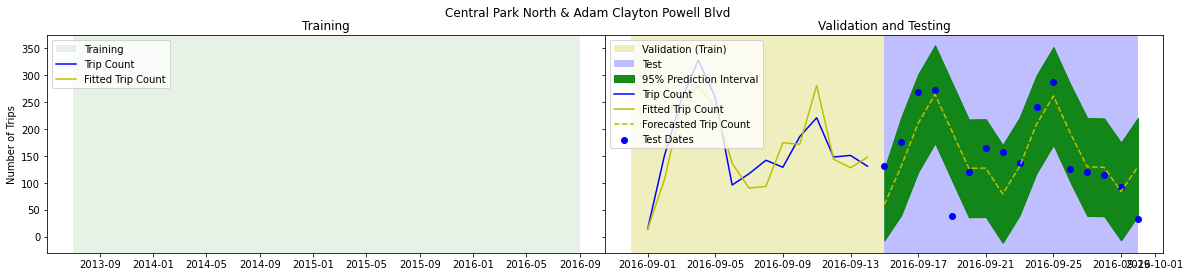

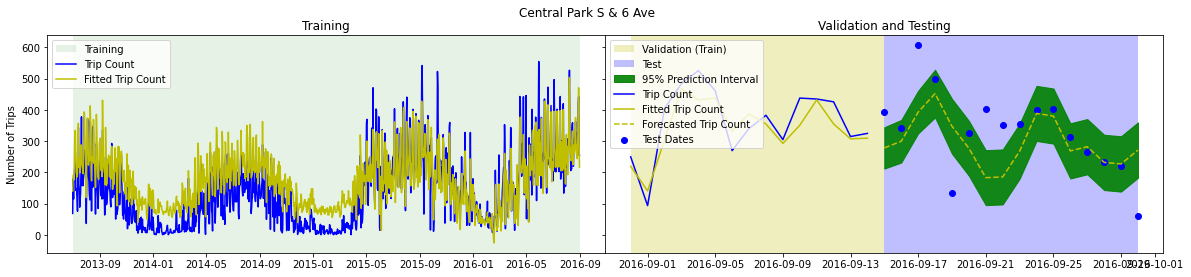

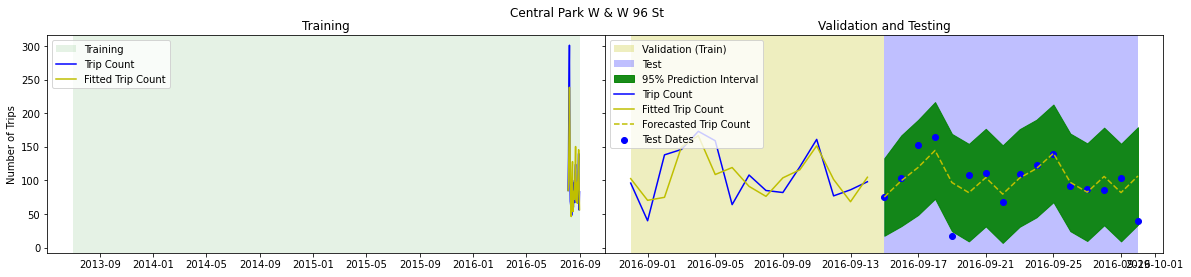

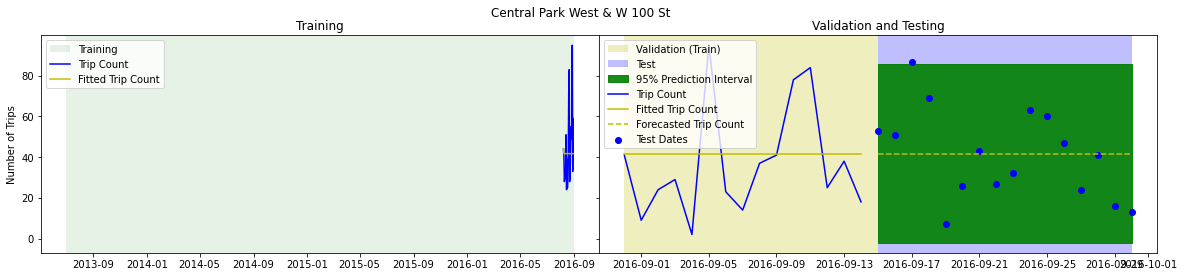

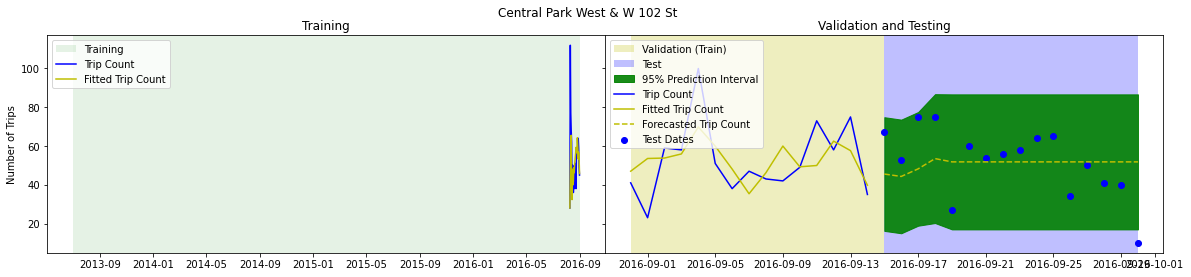

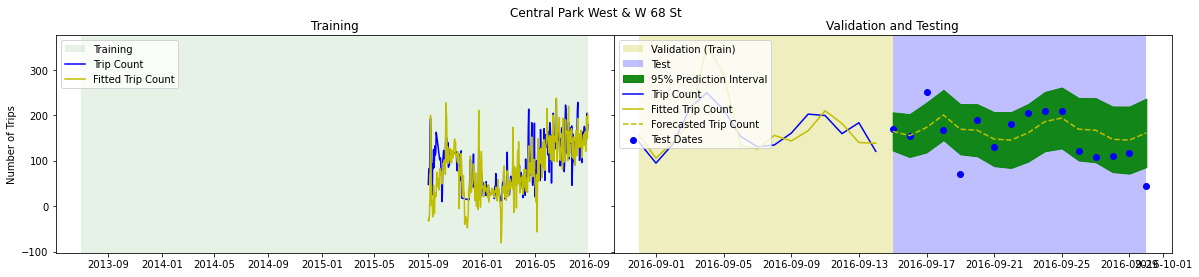

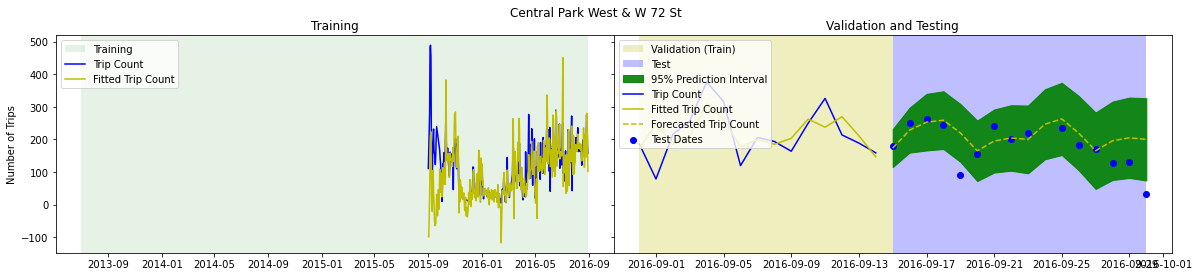

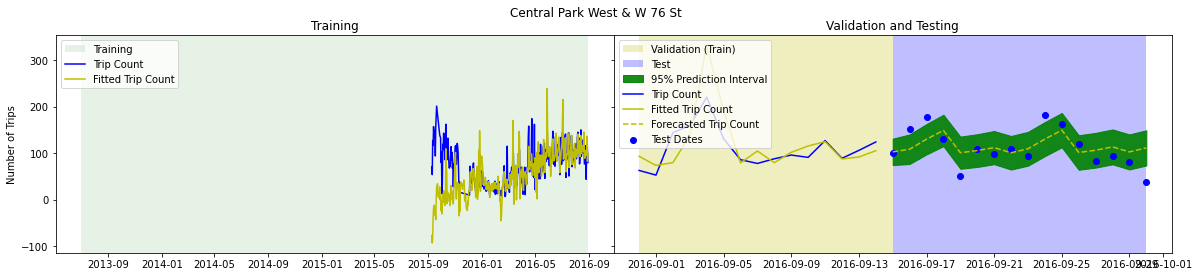

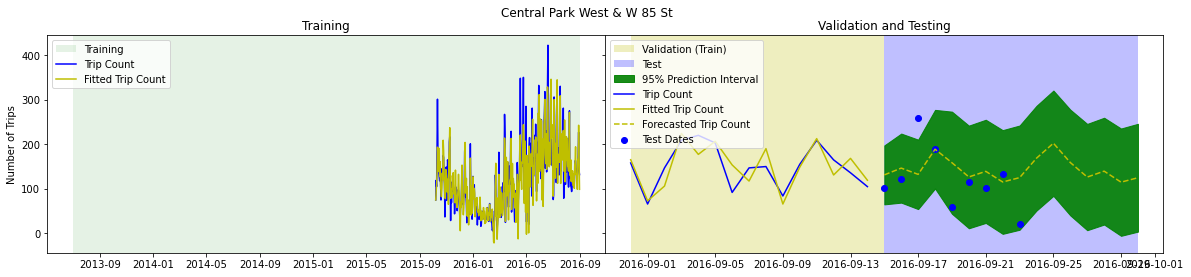

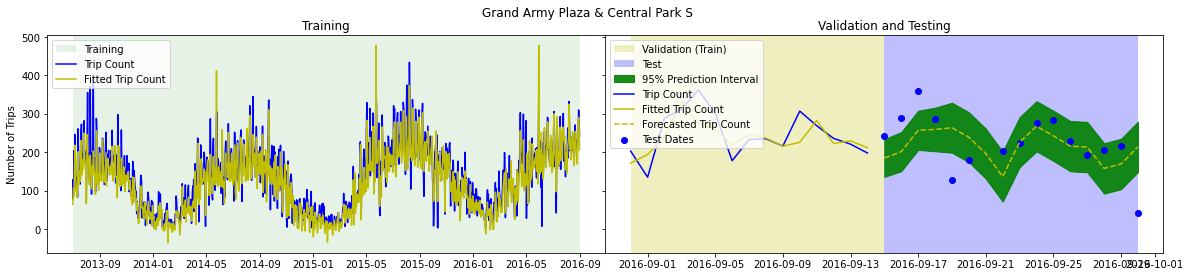

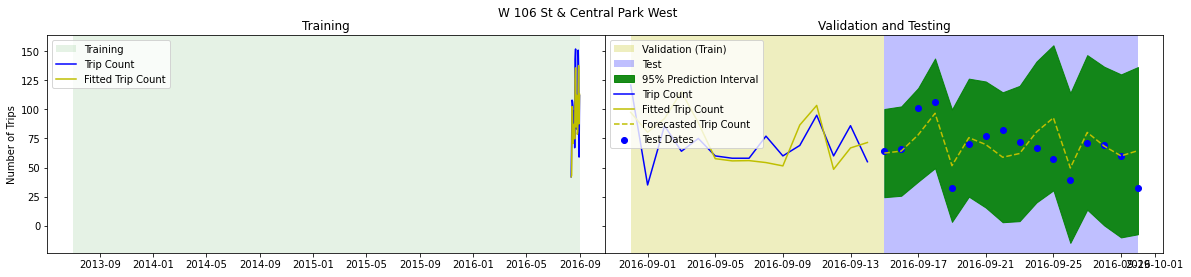

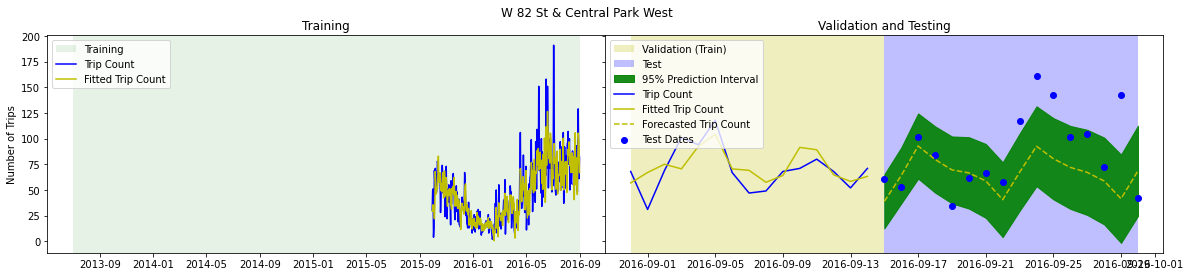

In [27]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_traindf = explain[(explain['start_station_name'] == st) & (explain['date'] < keyDates['val_start'][0])]
    fit_valdf = explain[(explain['start_station_name'] == st) & (explain['date'] >= keyDates['val_start'][0]) & (explain['date'] < keyDates['test_start'][0])]
    fit_testdf = explain[(explain['start_station_name'] == st) & (explain['date'] >= keyDates['test_start'][0])]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    axes[1].fill_between(fit_testdf['date'], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    #axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    axes[0].plot(fit_traindf['date'], fit_traindf['time_series_adjusted_data'], color = 'y', label = 'Fitted Trip Count')
    axes[1].plot(fit_valdf['date'], fit_valdf['time_series_adjusted_data'], color = 'y', label = 'Fitted Trip Count')
    axes[1].plot(fit_testdf['date'], fit_testdf['time_series_adjusted_data'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st)

    # display result
    plt.show()

## Using SQL to Calculate Metrics

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [44]:
query = f"""
WITH
    FORECAST AS (
        SELECT
            start_station_name, 
            EXTRACT(DATE from time_series_timestamp) as date,
            time_series_adjusted_data as forecast_value,
            time_series_type
        FROM ML.EXPLAIN_FORECAST(MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`, STRUCT({keyDates['forecast_horizon'][0]} AS horizon, 0.95 AS confidence_level))
        WHERE time_series_type = 'forecast'
    ),
    ACTUAL AS (
        SELECT start_station_name, date, sum(num_trips) as actual_value
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        WHERE splits = 'TEST'
        GROUP BY start_station_name, date
    ),
    COMBINED AS (
        SELECT *
        FROM FORECAST
        INNER JOIN ACTUAL
        USING (start_station_name, date)  
    ),
    DIFFS AS (
        SELECT start_station_name, date, 'forecast' as time_series_type, 
            actual_value, forecast_value, (actual_value - forecast_value) as diff
        FROM COMBINED
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.618697,45.268184,0.292053
1,Central Park S & 6 Ave,forecast,0.480986,91.400310,0.275717
2,Central Park W & W 96 St,forecast,0.475992,19.477062,0.197361
3,Central Park West & W 100 St,forecast,0.817914,17.937500,0.435508
4,Central Park West & W 102 St,forecast,0.506245,14.590289,0.281598
5,Central Park West & W 68 St,forecast,0.432341,41.465865,0.271351
6,Central Park West & W 72 St,forecast,0.569841,42.772539,0.235014
7,Central Park West & W 76 St,forecast,0.324317,26.061543,0.233605
8,Central Park West & W 85 St,forecast,0.879659,49.860256,0.406469
9,Grand Army Plaza & Central Park S,forecast,0.494944,59.281896,0.264730


Overall Metrics:

In [45]:
query = f"""
WITH
    FORECAST AS (
        SELECT
            start_station_name, 
            EXTRACT(DATE from time_series_timestamp) as date,
            time_series_adjusted_data as forecast_value,
            time_series_type
        FROM ML.EXPLAIN_FORECAST(MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`, STRUCT({keyDates['forecast_horizon'][0]} AS horizon, 0.95 AS confidence_level))
        WHERE time_series_type = 'forecast'
    ),
    ACTUAL AS (
        SELECT start_station_name, date, sum(num_trips) as actual_value
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        WHERE splits = 'TEST'
        GROUP BY start_station_name, date
    ),
    COMBINED AS (
        SELECT *
        FROM FORECAST
        INNER JOIN ACTUAL
        USING (start_station_name, date)  
    ),
    DIFFS AS (
        SELECT start_station_name, date, 'forecast' as time_series_type, 
            actual_value, forecast_value, (actual_value - forecast_value) as diff
        FROM COMBINED
    )
SELECT time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY time_series_type
ORDER BY time_series_type    
"""
customMetricsOverall = bigquery.query(query = query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE
0,forecast,0.502479,37.076469,0.274197


---
## Anomaly Detection
Reference for [`ML.DETECT_ANOMALIES`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies)


In [42]:
query = f"""
SELECT * EXCEPT(date), CAST(DATE(date) AS date) AS date
FROM ML.DETECT_ANOMALIES(MODEL `{PROJECT_ID}.{DATANAME}.{DATANAME}_arimaplus`, STRUCT(0.95 as anomaly_prob_threshold))
WHERE anomaly_probability >= 0.95
"""
anomalies = bigquery.query(query = query).to_dataframe()
anomalies

,start_station_name,num_trips,is_anomaly,lower_bound,upper_bound,anomaly_probability,date
0,Central Park S & 6 Ave,175.0,True,38.894500,171.162994,0.961844,2013-07-04
1,Central Park S & 6 Ave,89.0,True,110.101831,242.370325,0.989808,2013-07-17
2,Central Park S & 6 Ave,378.0,True,144.551864,276.820358,0.999987,2013-07-21
3,Central Park S & 6 Ave,242.0,True,250.654006,382.922500,0.973178,2013-07-28
4,Central Park S & 6 Ave,206.0,True,220.944758,353.213251,0.983400,2013-08-03
...,...,...,...,...,...,...,...
343,W 82 St & Central Park West,95.0,True,39.267577,91.809260,0.971908,2016-08-02
344,W 82 St & Central Park West,55.0,True,55.962319,108.504002,0.957799,2016-08-16
345,W 82 St & Central Park West,61.0,True,65.778204,118.319886,0.979212,2016-08-29
346,W 82 St & Central Park West,31.0,True,40.756482,93.298165,0.992302,2016-09-01


### Visualize Time Series with Forecast and Anomalies

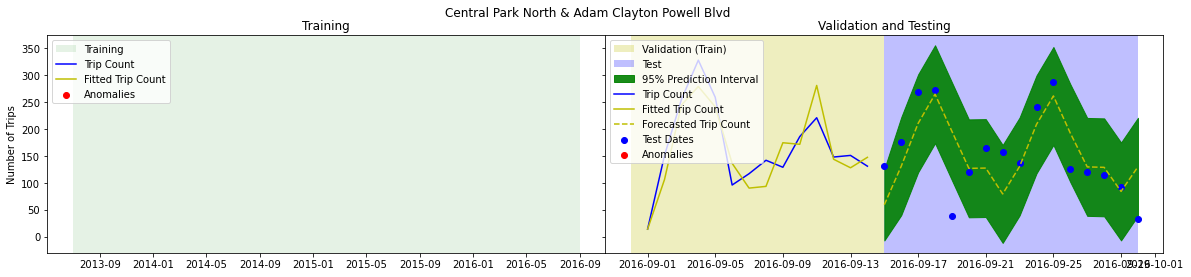

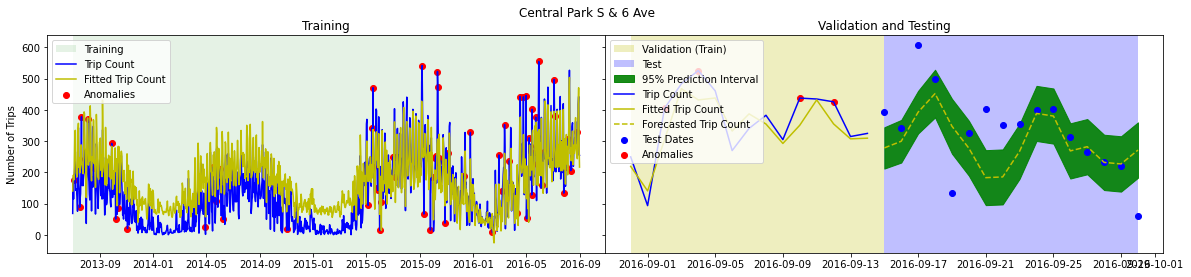

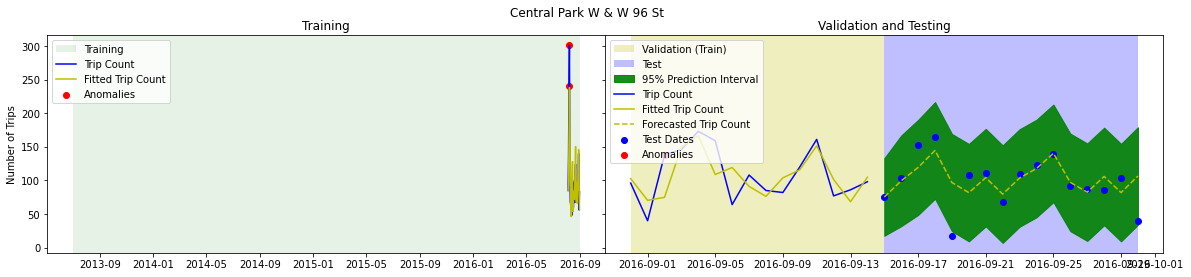

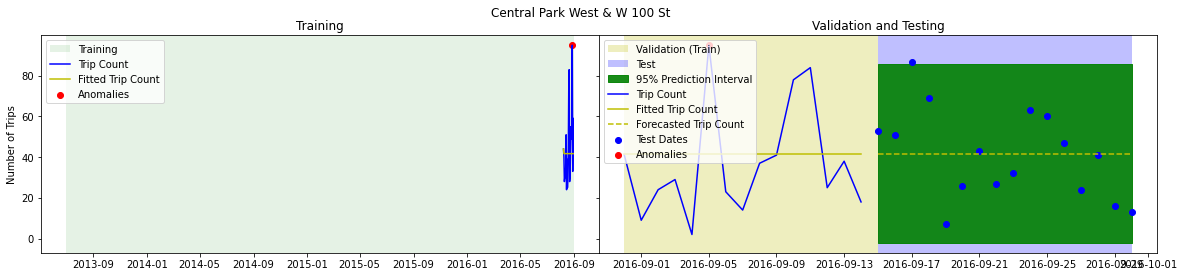

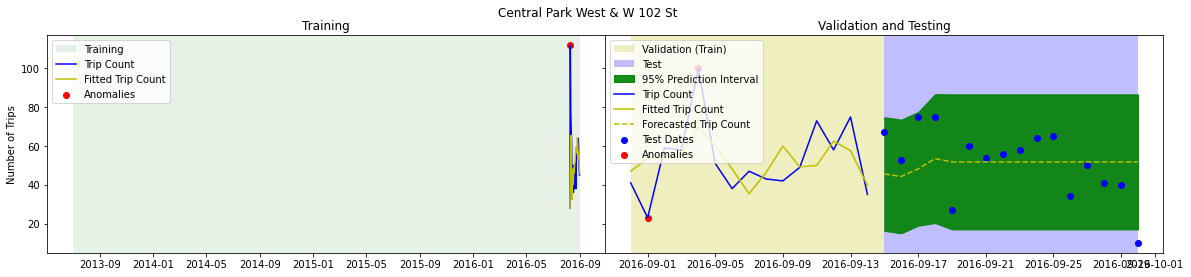

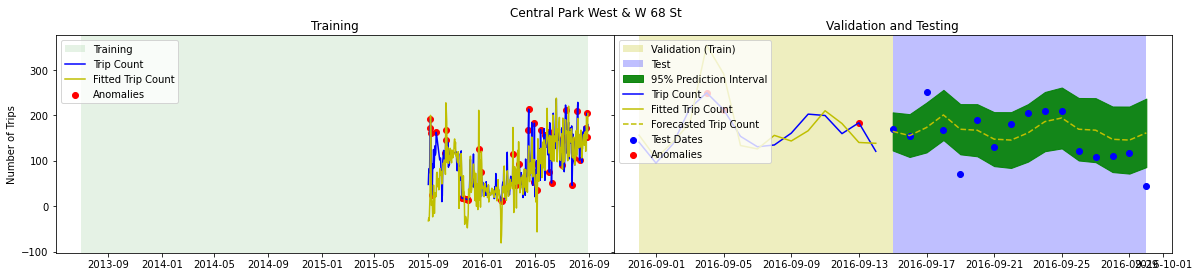

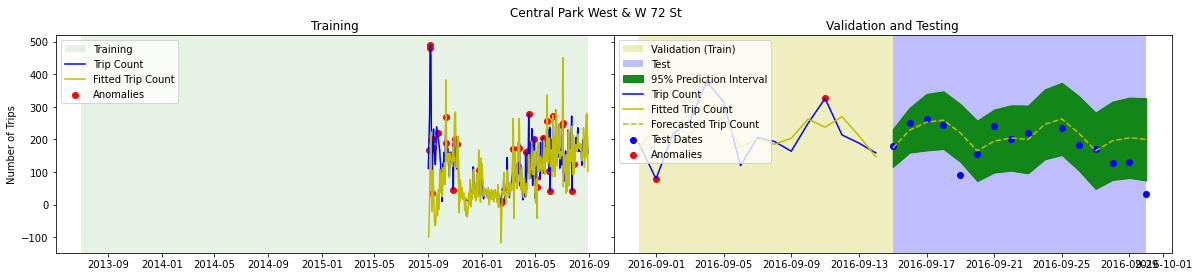

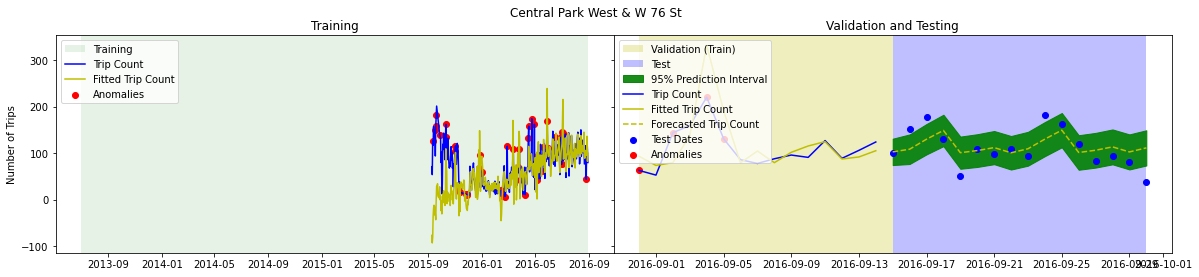

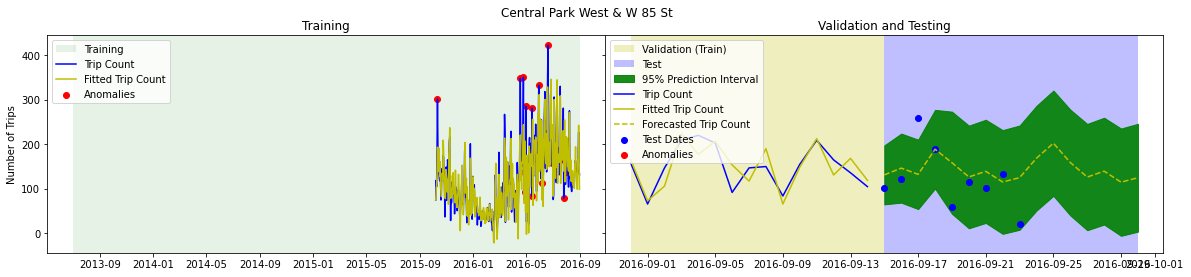

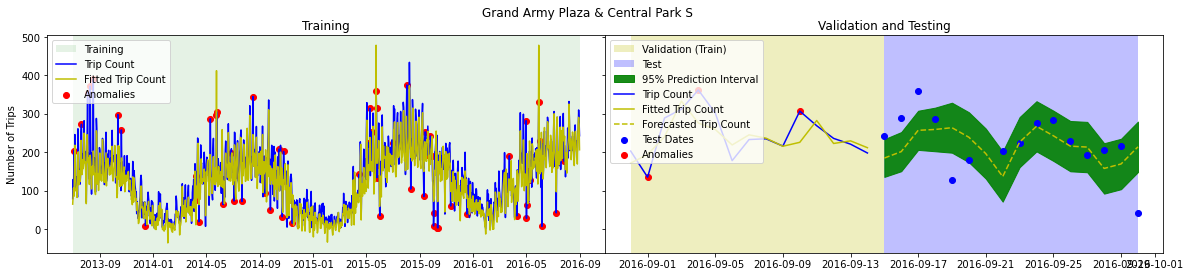

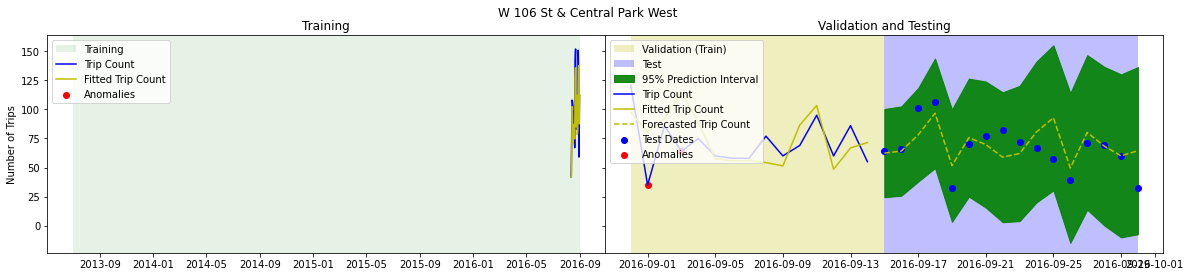

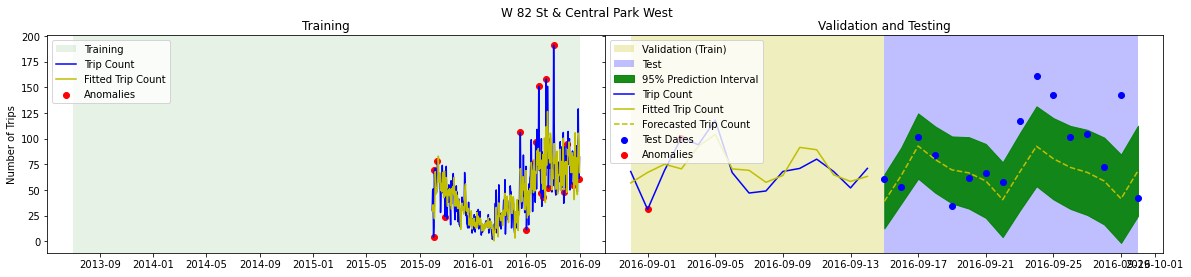

In [43]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_traindf = explain[(explain['start_station_name'] == st) & (explain['date'] < keyDates['val_start'][0])]
    fit_valdf = explain[(explain['start_station_name'] == st) & (explain['date'] >= keyDates['val_start'][0]) & (explain['date'] < keyDates['test_start'][0])]
    fit_testdf = explain[(explain['start_station_name'] == st) & (explain['date'] >= keyDates['test_start'][0])]
    anomalies_traindf = anomalies[(anomalies['start_station_name'] == st) & (anomalies['date'] < keyDates['val_start'][0])]
    anomalies_valdf = anomalies[(anomalies['start_station_name'] == st) & (anomalies['date'] >= keyDates['val_start'][0])]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    axes[1].fill_between(fit_testdf['date'], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    #axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    axes[0].plot(fit_traindf['date'], fit_traindf['time_series_adjusted_data'], color = 'y', label = 'Fitted Trip Count')
    axes[1].plot(fit_valdf['date'], fit_valdf['time_series_adjusted_data'], color = 'y', label = 'Fitted Trip Count')
    axes[1].plot(fit_testdf['date'], fit_testdf['time_series_adjusted_data'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    axes[0].scatter(anomalies_traindf['date'], anomalies_traindf['num_trips'], color = 'r', label = 'Anomalies')
    axes[1].scatter(anomalies_valdf['date'], anomalies_valdf['num_trips'], color = 'r', label = 'Anomalies')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st)

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"